In [ ]:
from ignite.metrics import FID

In [ ]:
import sys
sys.path.append('C:/Users/DELL/FGTD-master/scripts/')

# Import dependencies

In [ ]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
from tqdm.notebook import tqdm
from dataclasses import asdict, dataclass

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [ ]:
from preprocess import get_weighted_dataloader, extract_zip
from text_encoder.sentence_encoder import SentenceEncoder

In [ ]:
from pytorch_fid.inception import InceptionV3
from ignite.metrics import FID

from ignite.engine import *
from ignite.handlers import *
from ignite.metrics import *
from ignite.utils import *
from ignite.contrib.metrics.regression import *
from ignite.contrib.metrics import *

# Extracting the Dataset

You can download the dataset from Kaggle - https://www.kaggle.com/jessicali9530/celeba-dataset

Or from https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

In [ ]:
# File Constants
OUTPUT_DIR = "C:/Users/DELL/FGTD-master/dataset/img_align_celeba/"

# Data Loading

## Initialize Constants

In [ ]:
@dataclass
class Config:
  epochs: int = 32
  image_size: int = 128
  initial_size: int = 64
  noise_size: int = 100
  batch_size: int = 16
  subset_size: int = 20_000
  num_channels: int = 3

  device: 'typing.Any' = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
cfg = Config()
cfg_dict = asdict(cfg)

In [ ]:
sentence_encoder = SentenceEncoder(cfg.device)

# Initialize Helpers (for images)

In [ ]:
def show_grid(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

## Creating subset of dataset

In [ ]:
weighted_dataloader, weighted_dataiter = get_weighted_dataloader(
    'C:/Users/DELL/FGTD-master/dataset/celebA_Bangla.csv',
    image_location=OUTPUT_DIR,
    text_desc_location='C:/Users/DELL/FGTD-master/dataset/text_1_bn_descr_celeba.csv',
    transform=transforms.Compose([transforms.Resize((cfg.image_size, cfg.image_size)), transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]),
    batch_size=cfg.batch_size,
    subset_size=cfg.subset_size
)

Length of random indices: 20000
Classes present:  {'ধূসর_চুল', 'টাই_পরা', 'টাক', 'কালো_চুল', 'ঢেউ_খেলানো_চুল', 'অল্পবয়স্ক', 'কুচকানো_ভ্রু', 'মুখ_কিছুটা_খোলা', 'ফ্যাকাশে', 'লিপস্টিক_পরা', 'গোটি', 'হাসি', 'জুলফি', 'আকর্ষণীয়', 'মোছ', 'ডিম্বাকৃতির_চেহারা', 'চোখা_নাক', 'সোজা_চুল', 'টুপি_পরা', 'হালকা_দাড়ি', 'Unnamed: 0', 'বাদামী_চুল', 'দ্বীত্ব_থুতনি', 'মোটা', 'চশমা', 'সরু_চোখ', 'উঁচু_গালের_হাড়', 'বড়_নাক', 'পুরুষ', 'সোনালী_চুল', 'ঘন_ভ্রু', 'ভারী_মেকাপ', 'গোলাপী_গাল', 'বড়_ঠোঁট', 'সামনের চুল কম', 'কানের_দুল_পরা', 'নেকলেস_পরা'}
Number of classes:  37
Length of subset dataset: 20000


  0%|          | 0/20000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Using ImageTextDataset loader...


## Testing Dataloader output

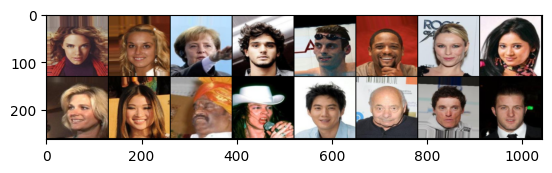

['মেয়েটির সোনালী চুল ছিল। মেয়েটির মুখ কিছুটা খোলা ছিল। মেয়েটির চোখা নাক ছিল। মেয়েটির ঢেউ খেলানো চুল ছিল। মেয়েটির লিপস্টিক পরা ছিল। ', 'মেয়েটির মুখে ভারী মেকাপ ছিল। মেয়েটির উঁচু গালের হাড় ছিল। মেয়েটির মুখ কিছুটা খোলা ছিল। মেয়েটির চেহারা ডিম্বাকৃতির। মেয়েটির চোখা নাক ছিল। মেয়েটির সামনের চুল কম ছিল। মেয়েটির মুখে ছিল হাসি। মেয়েটির লিপস্টিক পরা ছিল। ', 'ভদ্রমহিলাটির চোখের নিচে কালি ছিল। ভদ্রমহিলাটির কপালে ছড়ানো চুল ছিল। ভদ্রমহিলার সোনালী চুল ছিল। ভদ্রমহিলার সরু চোখ ছিল। ', 'ছেলেটির মুখে ছিল হালকা দাড়ি। ছেলেটির চোখের নিচে কালি ছিল। ছেলেটির বড় নাক ছিল। ছেলেটির সোনালী চুল ছিল। ছেলেটির মুখে গোটি দাঁড়ি ছিল। ছেলেটির ঢেউ খেলানো চুল ছিল। ', 'ছেলেটির চোখের নিচে কালি ছিল। ছেলেটির মুখ কিছুটা খোলা ছিল। ছেলেটির দাড়ি নেই। ', 'ছেলেটির চোখের নিচে কালি ছিল। ছেলেটির বড় নাক ছিল। ছেলেটির কালো চুল ছিল। ছেলেটি দেখতে মোটা ছিল। ছেলেটির দ্বীত্ব থুতনি ছিল। ছেলেটির মুখে গোটি দাঁড়ি ছিল। ছেলেটির উঁচু গালের হাড় ছিল। ছেলেটির মুখ কিছুটা খোলা ছিল। ছেলেটির চেহারা ডিম্বাকৃতির। ছেলেটির সামনের চুল কম ছিল। ছেলেটির মুখে ছিল হাসি

In [ ]:
images, labels, wrong_images = weighted_dataiter._next_data()
show_grid(torchvision.utils.make_grid(images, normalize=True))
print(labels)

# Initialize Weights

In [ ]:
def initialize_weights(model):
    className = model.__class__.__name__
    if className.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif className.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

# Generator Network

## Create Network

Hout = (Hin −1) × stride[0] − 2 × padding[0] + dilation[0] × (kernel_size[0] − 1) + output_padding[0] + 1

Wout = (Win −1) × stride[1] − 2 × padding[1] + dilation[1] × (kernel_size[1] − 1) + output_padding[1] + 1

In [ ]:
class Generator(nn.Module):
    '''
    The Generator Network
    '''

    def __init__(self, noise_size, feature_size, num_channels, embedding_size, reduced_dim_size):
        super(Generator, self).__init__()
        self.reduced_dim_size = reduced_dim_size

        self.projection = nn.Sequential(
            nn.Linear(in_features = embedding_size, out_features = reduced_dim_size),
            nn.BatchNorm1d(num_features = reduced_dim_size),
            nn.LeakyReLU(negative_slope = 0.2, inplace = True)
        )

        self.layer = nn.Sequential(
            nn.ConvTranspose2d(noise_size + reduced_dim_size, feature_size * 8, 4, 1, 0, bias = False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(negative_slope = 0.2, inplace = True),

            # state size (ngf*4) x 4 x 4
            nn.ConvTranspose2d(feature_size * 8, feature_size * 4, 4, 2, 1, bias = False),
            nn.BatchNorm2d(feature_size * 4),
            nn.ReLU(True),

            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(feature_size * 4, feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.ReLU(True),

            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(feature_size * 2, feature_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),

            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d(feature_size, feature_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),

            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d(feature_size, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()

        )
        self.optimizer = torch.optim.Adam(self.parameters(), lr = 0.0002, betas = (0.5, 0.5))

    def forward(self, noise, text_embeddings):
        encoded_text = self.projection(text_embeddings)
        concat_input = torch.cat([noise, encoded_text], dim = 1).unsqueeze(2).unsqueeze(2)
        output = self.layer(concat_input)
        return output

In [ ]:
generator = Generator(cfg.noise_size, cfg.image_size, cfg.num_channels, 768, 512)
generator.apply(initialize_weights)
generator.cuda()

Generator(
  (projection): Sequential(
    (0): Linear(in_features=768, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer): Sequential(
    (0): ConvTranspose2d(612, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2),

In [ ]:
count = 0
for p in generator.parameters():
    count+=len(p)
count

8804

## Test output shape of Generator

torch.Size([16, 3, 128, 128])


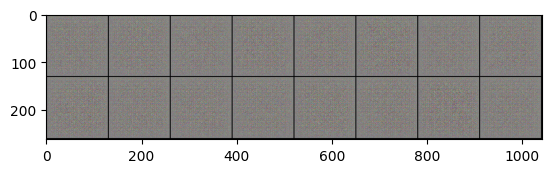

Generator(
  (projection): Sequential(
    (0): Linear(in_features=768, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer): Sequential(
    (0): ConvTranspose2d(612, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2),

In [ ]:
with torch.no_grad():
  generator.eval()
  noise = torch.randn(size=(cfg.batch_size, cfg.noise_size)).cuda()
  text_embeddings = sentence_encoder.convert_text_to_embeddings(labels)
  output = generator(noise, text_embeddings).detach()
  print(output.shape)
show_grid(torchvision.utils.make_grid(output.cpu(), normalize=True))
generator.train()

# Discriminator Network

## Create Network

Hout = ( (Hin + 2 × padding[0] − dilation[0] × (kernel_size[0] − 1) - 1) / stride[0]) + 1

Wout = ( (Win + 2 × padding[1] − dilation[1] × (kernel_size[1] − 1) - 1) / stride[1]) + 1


In [ ]:
class Discriminator(nn.Module):
    '''
    The Discriminator Network
    '''

    def __init__(self, num_channels, feature_size, embedding_size, reduced_dim_size):
        super(Discriminator, self).__init__()
        self.reduced_dim_size = reduced_dim_size

        ## Image Encoder
        self.netD_1 = nn.Sequential(
            # input nc x 128 x 128
            nn.Conv2d(num_channels, feature_size, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),

            # input nc x 64 x 64
            nn.Conv2d(feature_size, feature_size, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),

            # state size ndf x 32 x 32
            nn.Conv2d(feature_size, feature_size * 2, 4, 2, 1, bias = False),
            nn.BatchNorm2d(feature_size * 2),
            nn.LeakyReLU(0.2, inplace = True),

            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(feature_size * 2, feature_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(feature_size * 4, feature_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(0.2, inplace=True),

        )

        ## Text Encoder
        self.projector = nn.Sequential(
            nn.Linear(in_features=embedding_size, out_features=reduced_dim_size),
            nn.BatchNorm1d(num_features=reduced_dim_size),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        ## Text + Image Concat Layer
        self.netD_2 = nn.Sequential(
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(feature_size * 8 + reduced_dim_size, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

        self.optimizer = torch.optim.Adam(self.parameters(), lr = 0.0001, betas = (0.5, 0.5))

    def forward(self, input_img, text_embeddings):
        x_intermediate = self.netD_1(input_img)

        projected_embed = self.projector(text_embeddings)

        replicated_embed = projected_embed.repeat(4, 4, 1, 1).permute(2,  3, 0, 1)
        hidden_concat = torch.cat([x_intermediate, replicated_embed], 1)

        x = self.netD_2(hidden_concat)

        return x.view(-1, 1), x_intermediate

In [ ]:
discriminator = Discriminator(cfg.num_channels, cfg.image_size, 768, 512)
discriminator.apply(initialize_weights)
discriminator.cuda()

Discriminator(
  (netD_1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slo

In [ ]:
count = 0
for p in discriminator.parameters():
    count+=len(p)
count

7681

## Test output shape of Discriminator

In [ ]:
with torch.no_grad():
  discriminator.eval()
  validity, _ = discriminator(output, text_embeddings)
  print(validity.shape)
discriminator.train()

torch.Size([16, 1])


Discriminator(
  (netD_1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slo

# Specifying Loss Functions

In [ ]:
criterion = nn.BCELoss().cuda()
l2_loss = nn.MSELoss().cuda()
l1_loss = nn.L1Loss().cuda()

# Plotting output after each epoch

This is just to generate a batch of text embeddings to be used to plot

In [ ]:
plt_images, plt_labels, _ = weighted_dataiter._next_data()
plt_o_text_embeddings = sentence_encoder.convert_text_to_embeddings(plt_labels)
plt_o_text_embeddings.shape

torch.Size([16, 768])

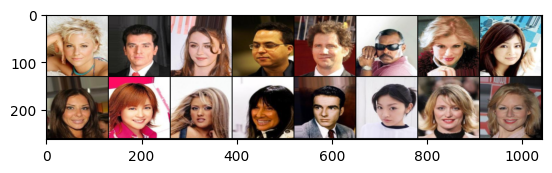

['মেয়েটির ভ্রু কুচকানো ছিল। মেয়েটির সোনালী চুল ছিল। মেয়েটির মুখে ভারী মেকাপ ছিল। মেয়েটির চোখা নাক ছিল। মেয়েটির মুখে ছিল হাসি। মেয়েটির কানে দুল পরা ছিল। মেয়েটির লিপস্টিক পরা ছিল। মেয়েটির নেকলেস পরা ছিল। ', 'ভদ্রলোকের কালো চুল ছিল। ভদ্রলোকের সোনালী চুল ছিল। ভদ্রলোকের উঁচু গালের হাড় ছিল। ভদ্রলোকের দাড়ি নেই। ভদ্রলোকটির ঢেউ খেলানো চুল ছিল। ভদ্রলোকটির টাই পরা ছিল। ', 'মেয়েটির ভ্রু কুচকানো ছিল। মেয়েটির বড় ঠোঁট ছিল। মেয়েটির সোনালী চুল ছিল। মেয়েটির মুখে ভারী মেকাপ ছিল। মেয়েটির সরু চোখ ছিল। মেয়েটির চেহারা ডিম্বাকৃতির। মেয়েটির ঢেউ খেলানো চুল ছিল। মেয়েটির লিপস্টিক পরা ছিল। ', 'ছেলেটির বড় নাক ছিল। ছেলেটির কালো চুল ছিল। ছেলেটি দেখতে মোটা ছিল। ছেলেটির চোখে চশমা ছিল। ছেলেটির দাড়ি নেই। ছেলেটির সোজা চুল ছিল। ', 'ছেলেটির মুখে ছিল হালকা দাড়ি। ছেলেটির চোখের নিচে কালি ছিল। ছেলেটির বড় নাক ছিল। ছেলেটির সোনালী চুল ছিল। ছেলেটির উঁচু গালের হাড় ছিল। ছেলেটির দাড়ি নেই। ছেলেটির মুখে ছিল হাসি। ছেলেটির ঢেউ খেলানো চুল ছিল। ছেলেটির টাই পরা ছিল। ', 'ভদ্রলোকের কালো চুল ছিল। ভদ্রলোকের চোখে চশমা ছিল। ভদ্রলোকের মুখে মোছ ছিল।

In [ ]:
show_grid(torchvision.utils.make_grid(plt_images.cpu(), normalize=True))
print(plt_labels)

In [ ]:
fixed_noise = torch.randn(size=(len(plt_labels), cfg.noise_size)).cuda()

In [ ]:
def plot_output(epoch):
  plt.clf()
  with torch.no_grad():

    generator.eval()
    test_images = generator(fixed_noise, plt_o_text_embeddings)
    generator.train()

    grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
    show_grid(grid)


In [ ]:
# wrapper class as feature_extractor
class WrapperInceptionV3(nn.Module):

    def __init__(self, fid_incv3):
        super().__init__()
        self.fid_incv3 = fid_incv3

    @torch.no_grad()
    def forward(self, x):
        y = self.fid_incv3(x)
        y = y[0]
        y = y[:, :, 0, 0]
        return y

# use cpu rather than cuda to get comparable results
device = "cpu"

# pytorch_fid model
dims = 2048
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
model = InceptionV3([block_idx]).to(device)

# wrapper model to pytorch_fid model
wrapper_model = WrapperInceptionV3(model)
wrapper_model.eval();

# comparable metric
pytorch_fid_metric = FID(num_features=dims, feature_extractor=wrapper_model)

def eval_step(engine, batch):
    return batch
default_evaluator = Engine(eval_step)

pytorch_fid_metric.attach(default_evaluator, "fid")

# Performance metric calculation

In [ ]:
generator_path = 'C:/Users/DELL/FGTD-master/Face-GANs/DCGAN/DCGAN sbnltk gd generators/'

In [ ]:
FID_scores = []

In [ ]:
epoch_number = 0

for i, (real_images, real_text, wrong_images) in enumerate(weighted_dataloader):
    if(epoch_number>150):
        break
    current_batch_size = real_images.size()[0]

    current_path = generator_path + str(epoch_number) + '.pt'
    #current_path = generator_path+ 'cp.pt'

    generator.load_state_dict(torch.load(current_path)['generator_sd'])

    #converting to cuda
    real_images = real_images.cuda()
    text_embeddings = sentence_encoder.convert_text_to_embeddings(real_text)

    input_noise = torch.randn(size=(current_batch_size, cfg.noise_size)).cuda()
    fake_images = generator(input_noise, text_embeddings)

    state = default_evaluator.run([[real_images, fake_images]])
    print(state.metrics["fid"])

    FID_scores.append(state.metrics["fid"])

    epoch_number+=10



429.1269918181616
248.68225147605048
215.2560269997383
204.37390043081342
190.06858914349522
210.63557493114405
190.8918120651402
183.57371424642744
187.40312961471756
187.89109741091664
208.1943395265013
186.8808306674335
218.01331195171008
221.1232831967762
213.15526794882604


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/DELL/FGTD-master/Face-GANs/DCGAN/DCGAN sbnltk gd generators/150.pt'

# FID at different epochs

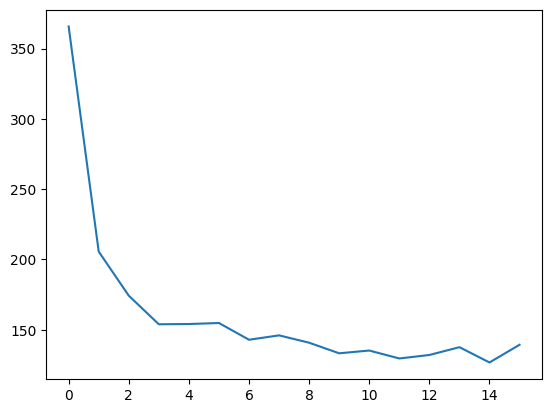

In [ ]:
plt.plot(FID_scores)
plt.show()